# Will the Covid-19 pandemic be influenced by weather: the case of Zurich, Switzerland

BDA Group 25

20-742-151 Haoxin Cai

20-743-696 Hongjie Guan

19-764-786 Weiyi Wang

20-741-310 Yuanyuan Huang

20-742-227 Ziting Li

## Introduction

Since its debut in Dec, 2019, COVID-19 never ceases to be an ongoing global pandemic. Up to now, more than 170 million of cases have been confirmed, in which almost 4 million people died of this evil malady. 

Experts believe that the virus causing COVID-19, a.k.a. SARS-CoV-2, spreads mainly from person to person. Respiratory droplets and airborne particles are the pricniple vector of transmission. Hence, WHO and governments authorities have suggested people to cancel personal gathering and maintain social distance in daily life.                 
                           
We notice that in **rainy** and **cloudy** days people are less likely to join group gathering than in **sunny** days. This project endeavors to find **whether covid-19 situation (i.e. cases per day, reproductive value) in our city Zürich is related to weather conditions (i.e. avg. temperature, precipitaion, etc.)**. The data of covid cases used in the study came from Canton Zurich [Open Data Resource](https://www.zh.ch/de/politik-staat/opendata.html?keyword=ogd#/details/671@gesundheitsdirektion-kanton-zuerich). The historical weather data used in this study are collected from the Federal Office of Meteorology and Climatology [MeteoSwiss](https://www.meteoswiss.admin.ch/home.html?tab=overview).

In [1]:
import random
import pandas as pd
import numpy as np
import statsmodels.api as sm 
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


## 1. Data Collection and Data Cleaning

### Import Meteorology and Climatology data of Zurich


In [2]:
url="https://raw.githubusercontent.com/HJGuan/Will_Weather_effect_the_spread_of_Pandemic/main/Zurich_Meteorology_and_Climatology_data.csv"
weather_raw = pd.read_csv(url)
weather_raw.shape

(4175, 12)

In [3]:
weather_raw.head()

,station/location,date,gre000d0,hto000d0,nto000d0,prestad0,rre150d0,sre000d0,tre200d0,tre200dn,tre200dx,ure200d0
0,SMA,20100101,16,0,100,929.7,5.7,0,2.5,-0.9,4.3,94.3
1,SMA,20100102,53,1,63,950.0,0.0,175,-2.5,-4.8,-0.9,72.8
2,SMA,20100103,74,1,25,953.6,0.0,441,-4.4,-6.5,-1.0,70.6
3,SMA,20100104,65,1,38,947.1,0.0,326,-6.1,-8.2,-2.9,79.2
4,SMA,20100105,22,1,96,938.5,1.0,0,-5.9,-7.5,-5.0,86.2


According to MeteoSwiss, the parameter and their units, discription, renaming are as follows:

|Parameters|Unit|Discription|Rename|
|---|---|---|---|
|gre000d0	|W/m²	|Global radiation; daily mean|Rad(W/m²)|
|hto000d0	|cm	|Total snow depth; morning recording at 6 UTC|SnowDept(cm)|
|nto000d0	|%	|Cloud cover; daily mean|CloudCov(%)|
|prestad0	|hPa	|Pressure at station level (QFE); daily mean|Press(hPa)|
|rre150d0	|mm	|Precipitation; daily total 6 UTC - 6 UTC following day|Precipiation(mm)|
|sre000d0	|min	|Sunshine duration; daily total|SunDur(min)|
|tre200d0	|°C	|Air temperature 2 m above ground; daily mean|MeanTemp(°C)|
|tre200dn	|°C	|Air temperature 2 m above ground; daily minimum|MinTemp(°C)|
|tre200dx	|°C	|Air temperature 2 m above ground; daily maximum|MaxTemp(°C)|
|ure200d0	|%	|Relative air humidity; 2 m above ground; daily mean|RelateHumid(%)|



In [4]:
#drop irrelevant columns: station/location: SMA indicates weather around Zurich
weather_zh=weather_raw.drop(['station/location'],axis=1)
#rename colomns
weather_zh=weather_zh.rename(columns={'gre000d0':'Rad',
'hto000d0':'SnowDept',
'nto000d0':'CloudCov',
'prestad0':'Press',
'rre150d0':'Precipiation',
'sre000d0':'SunDur',
'tre200d0':'MeanTemp',
'tre200dn':'MinTemp',
'tre200dx':'MaxTemp',
'ure200d0':'RelateHumid',
})

weather_zh.head()

,date,Rad,SnowDept,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
0,20100101,16,0,100,929.7,5.7,0,2.5,-0.9,4.3,94.3
1,20100102,53,1,63,950.0,0.0,175,-2.5,-4.8,-0.9,72.8
2,20100103,74,1,25,953.6,0.0,441,-4.4,-6.5,-1.0,70.6
3,20100104,65,1,38,947.1,0.0,326,-6.1,-8.2,-2.9,79.2
4,20100105,22,1,96,938.5,1.0,0,-5.9,-7.5,-5.0,86.2


### Import covid-19 pandemic data of Kanton Zurich


In [5]:
# Import Covid-19 data of Zurich, this shows the accumulative cases. We have to calculate cases per day in the next code chain. 
url_zh='https://github.com/openZH/covid_19/blob/master/fallzahlen_kanton_zh/COVID19_Fallzahlen_Kanton_ZH_total.csv?raw=true'
case_zh = pd.read_csv(url_zh)
case_zh=case_zh[['date','ncumul_conf']]
case_zh.head()

,date,ncumul_conf
0,2020-02-27,2
1,2020-02-28,2
2,2020-02-29,6
3,2020-03-01,7
4,2020-03-02,10


In [6]:
# Calculate cases per day 
case_zh['cases_pday'] = case_zh['ncumul_conf'].diff()
case_zh=case_zh.rename(columns={'ncumul_conf': 'cases_all'})
case_zh=case_zh.loc[3:428]
case_zh=case_zh.reset_index(drop = True)
case_zh

,date,cases_all,cases_pday
0,2020-03-01,7,1.0
1,2020-03-02,10,3.0
2,2020-03-03,13,3.0
3,2020-03-04,15,2.0
4,2020-03-05,23,8.0
...,...,...,...
421,2021-04-26,105212,266.0
422,2021-04-27,105628,416.0
423,2021-04-28,105988,360.0
424,2021-04-29,106303,315.0


In [7]:
# Import Re value (reproductive value) of Kanton Zurich (Date: 2020-03-01 to 2021-04-30)
url_re = 'https://github.com/covid-19-Re/dailyRe-Data/blob/master/CHE-confCasesSWestimates.csv?raw=true'
rep_ch = pd.read_csv(url_re)
rep_ch = rep_ch[['date','median_R_mean']]
rep_zh = rep_ch.iloc[11140:11566]
rep_zh = rep_zh.reset_index(drop = True)
rep_zh = rep_zh.rename(columns={'median_R_mean': 'R_value'})
rep_zh.head()

,date,R_value
0,2021-02-27,1.22
1,2021-02-28,1.23
2,2021-03-01,1.24
3,2021-03-02,1.23
4,2021-03-03,1.22


### Combine data

In [8]:
#format date 
from datetime import datetime

def format_date(date):
    date2 = datetime.strptime(str(date), '%Y%m%d').strftime('%Y-%m-%d')
    return date2

weather_zh['date'] = weather_zh['date'].apply(format_date)

In [9]:
case_zh_indexed = case_zh.set_index('date')
rep_zh_indexed = rep_zh.set_index('date')
weather_zh_indexed = weather_zh.set_index('date')

In [10]:
#concat data according to date
df = pd.concat([case_zh_indexed, rep_zh_indexed, weather_zh_indexed], axis=1, join='inner')
df

,cases_all,cases_pday,R_value,Rad,SnowDept,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
date,,,,,,,,,,,,,
2020-03-01,7,1.0,2.68,167,0,42,937.6,0.8,482,7.5,3.9,13.2,71.0
2020-03-02,10,3.0,2.57,46,0,92,929.2,4.6,0,4.6,1.5,7.0,76.6
2020-03-03,13,3.0,2.47,138,0,92,940.7,0.6,323,3.9,1.9,8.2,67.2
2020-03-04,15,2.0,2.41,148,0,79,947.8,0.9,325,4.1,0.5,8.5,69.5
2020-03-05,23,8.0,2.36,23,0,100,935.2,13.9,0,4.7,2.8,7.0,88.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,105212,266.0,0.86,257,0,46,947.6,0.0,623,11.0,5.6,17.3,41.2
2021-04-27,105628,416.0,0.85,302,0,33,941.1,0.0,790,11.7,4.3,18.5,44.4
2021-04-28,105988,360.0,0.86,202,0,71,940.1,8.7,278,13.0,8.9,19.8,60.3


In [11]:
#check data types
df.dtypes

cases_all         int64
cases_pday      float64
R_value         float64
Rad               int64
SnowDept         object
CloudCov         object
Press           float64
Precipiation    float64
SunDur            int64
MeanTemp        float64
MinTemp         float64
MaxTemp         float64
RelateHumid     float64
dtype: object

In [12]:
def convert_datatype(df):
    NaN_Num=0
    for col in df: 
        for i in df.index.tolist():
            try:
                df[col][i]=float(df[col][i])
            except:
                print(df[col][i]+"  postion at :"+col+","+i)
                NaN_Num=NaN_Num+1
    print("Number of abnormal value:"+ str(NaN_Num))


convert_datatype(df)

C:\Users\Guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-  postion at :CloudCov,2020-10-25
Number of abnormal value:1


In [13]:
# We found there is 1 missing value: the Cloud Coverage data of 2020-10-25.
# We replace it with the average value of the previous and next day.
df['CloudCov']['2020-10-25']=(df['CloudCov']['2020-10-24']+df['CloudCov']['2020-10-26'])/2

C:\Users\Guan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df['CloudCov']['2020-10-25']

87.5

In [15]:
df['CloudCov']=pd.to_numeric(df['CloudCov'],downcast='float')

In [16]:
df.dtypes

cases_all         int64
cases_pday      float64
R_value         float64
Rad               int64
SnowDept         object
CloudCov        float32
Press           float64
Precipiation    float64
SunDur            int64
MeanTemp        float64
MinTemp         float64
MaxTemp         float64
RelateHumid     float64
dtype: object

Convert data types of the dataframe to numeric. Check again the data types

In [17]:
df

,cases_all,cases_pday,R_value,Rad,SnowDept,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
date,,,,,,,,,,,,,
2020-03-01,7,1.0,2.68,167,0,42.0,937.6,0.8,482,7.5,3.9,13.2,71.0
2020-03-02,10,3.0,2.57,46,0,92.0,929.2,4.6,0,4.6,1.5,7.0,76.6
2020-03-03,13,3.0,2.47,138,0,92.0,940.7,0.6,323,3.9,1.9,8.2,67.2
2020-03-04,15,2.0,2.41,148,0,79.0,947.8,0.9,325,4.1,0.5,8.5,69.5
2020-03-05,23,8.0,2.36,23,0,100.0,935.2,13.9,0,4.7,2.8,7.0,88.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,105212,266.0,0.86,257,0,46.0,947.6,0.0,623,11.0,5.6,17.3,41.2
2021-04-27,105628,416.0,0.85,302,0,33.0,941.1,0.0,790,11.7,4.3,18.5,44.4
2021-04-28,105988,360.0,0.86,202,0,71.0,940.1,8.7,278,13.0,8.9,19.8,60.3


In [18]:
df0= df.reset_index()

In [19]:
df0.head()

,date,cases_all,cases_pday,R_value,Rad,SnowDept,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
0,2020-03-01,7,1.0,2.68,167,0,42.0,937.6,0.8,482,7.5,3.9,13.2,71.0
1,2020-03-02,10,3.0,2.57,46,0,92.0,929.2,4.6,0,4.6,1.5,7.0,76.6
2,2020-03-03,13,3.0,2.47,138,0,92.0,940.7,0.6,323,3.9,1.9,8.2,67.2
3,2020-03-04,15,2.0,2.41,148,0,79.0,947.8,0.9,325,4.1,0.5,8.5,69.5
4,2020-03-05,23,8.0,2.36,23,0,100.0,935.2,13.9,0,4.7,2.8,7.0,88.2


The cleaned dataframe contains the following attributes:

|Field Name|Unit|Discription|
|---|---|---|
|date | |2020-03-01 to 2021-04-30|
|cases_all | |Reported number of confirmed cases as of date in Zurich|
|cases_pday | |Reported number of confirmed cases on date in Zurich|
|R_value | |Mean estimated median R|
|Rad|W/m²	|Global radiation; daily mean|
|SnowDept	|cm	|Total snow depth; morning recording at 6 UTC|
|CloudCov	|%	|Cloud cover; daily mean|
|Press	|hPa	|Pressure at station level (QFE); daily mean|
|Precipiation	|mm	|Precipitation; daily total 6 UTC - 6 UTC following day|
|SunDur	|min	|Sunshine duration; daily total|
|MeanTemp	|°C	|Air temperature 2 m above ground; daily mean|
|MinTemp	|°C	|Air temperature 2 m above ground; daily minimum|
|MaxTemp	|°C	|Air temperature 2 m above ground; daily maximum|
|RelateHumid	|%	|Relative air humidity; 2 m above ground; daily mean|


## 2. Exploratory Data Analysis

### Visualization

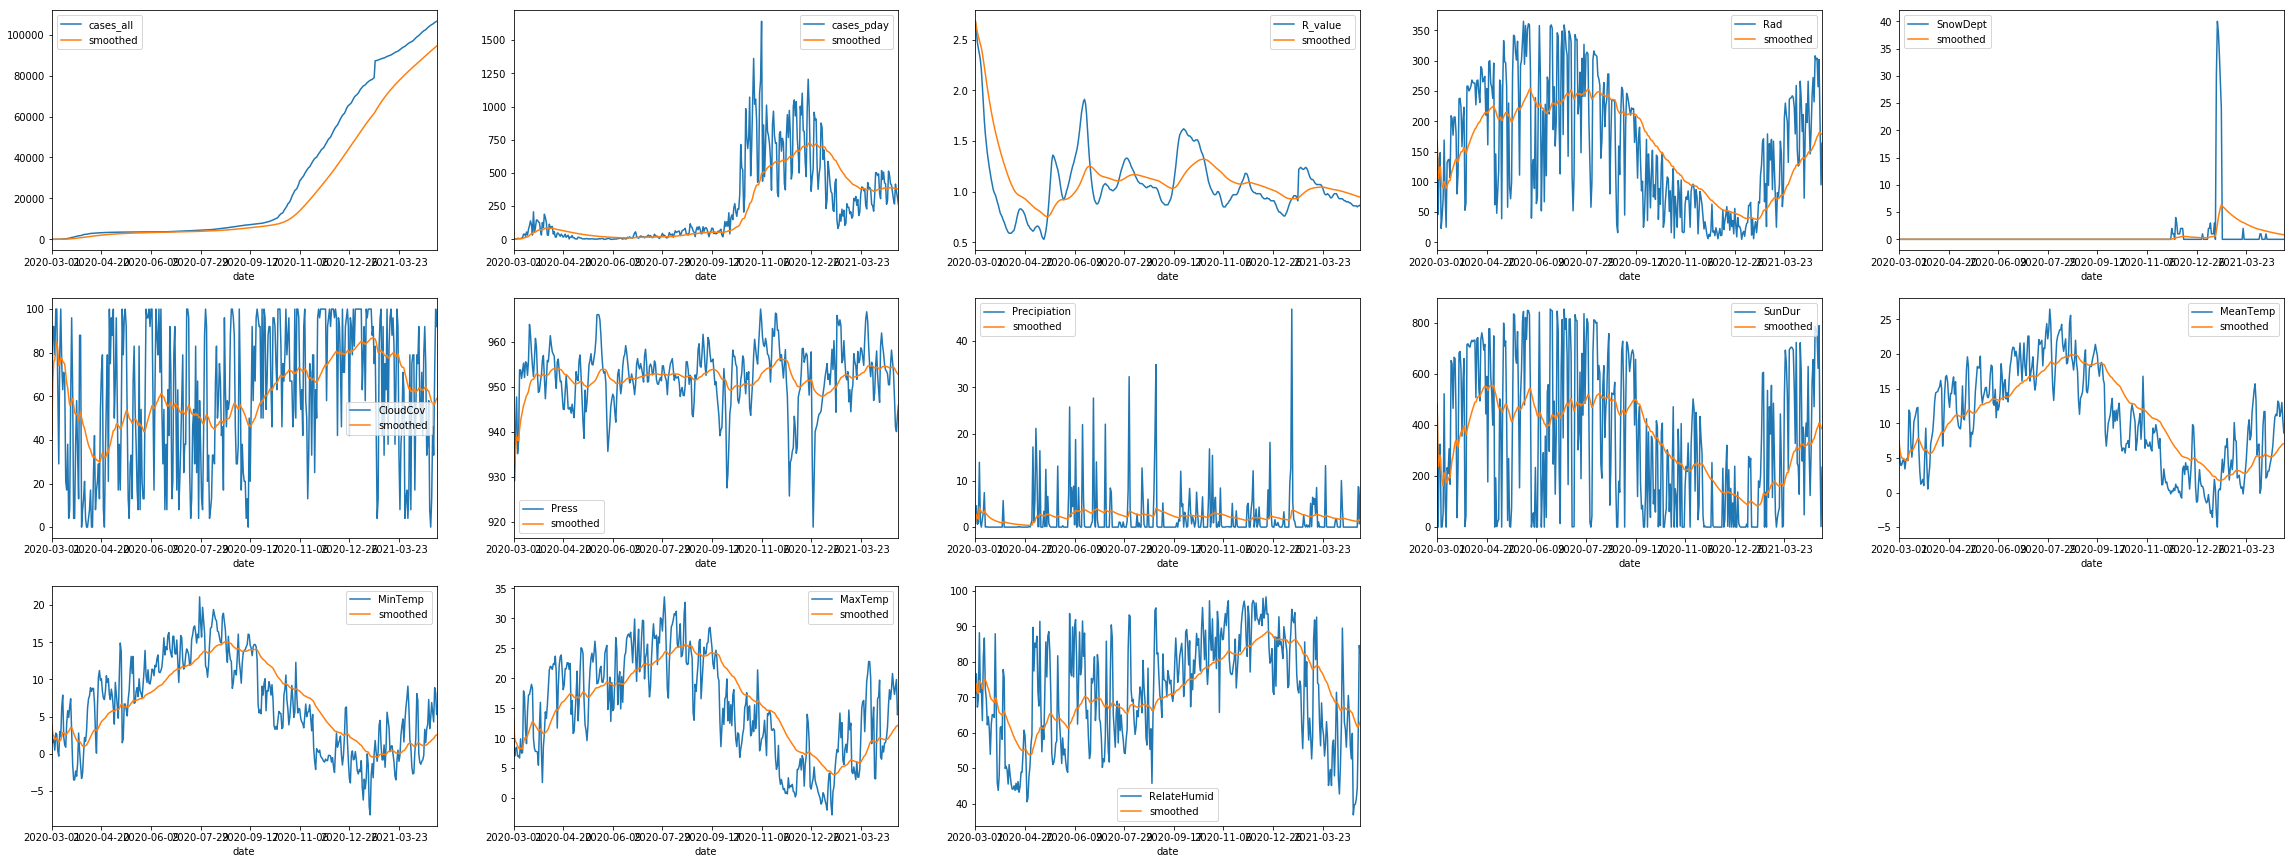

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(40, 15))
for i, idx in enumerate(df.columns):
  df[idx].plot(ax=axes.flat[i], legend = True)
  df[idx].ewm(span=60).mean().plot(ax=axes.flat[i], label='smoothed',legend = True)
fig.delaxes(axes[2,3])
fig.delaxes(axes[2,4])

Below we use histograms to collect and visualize some statistics.

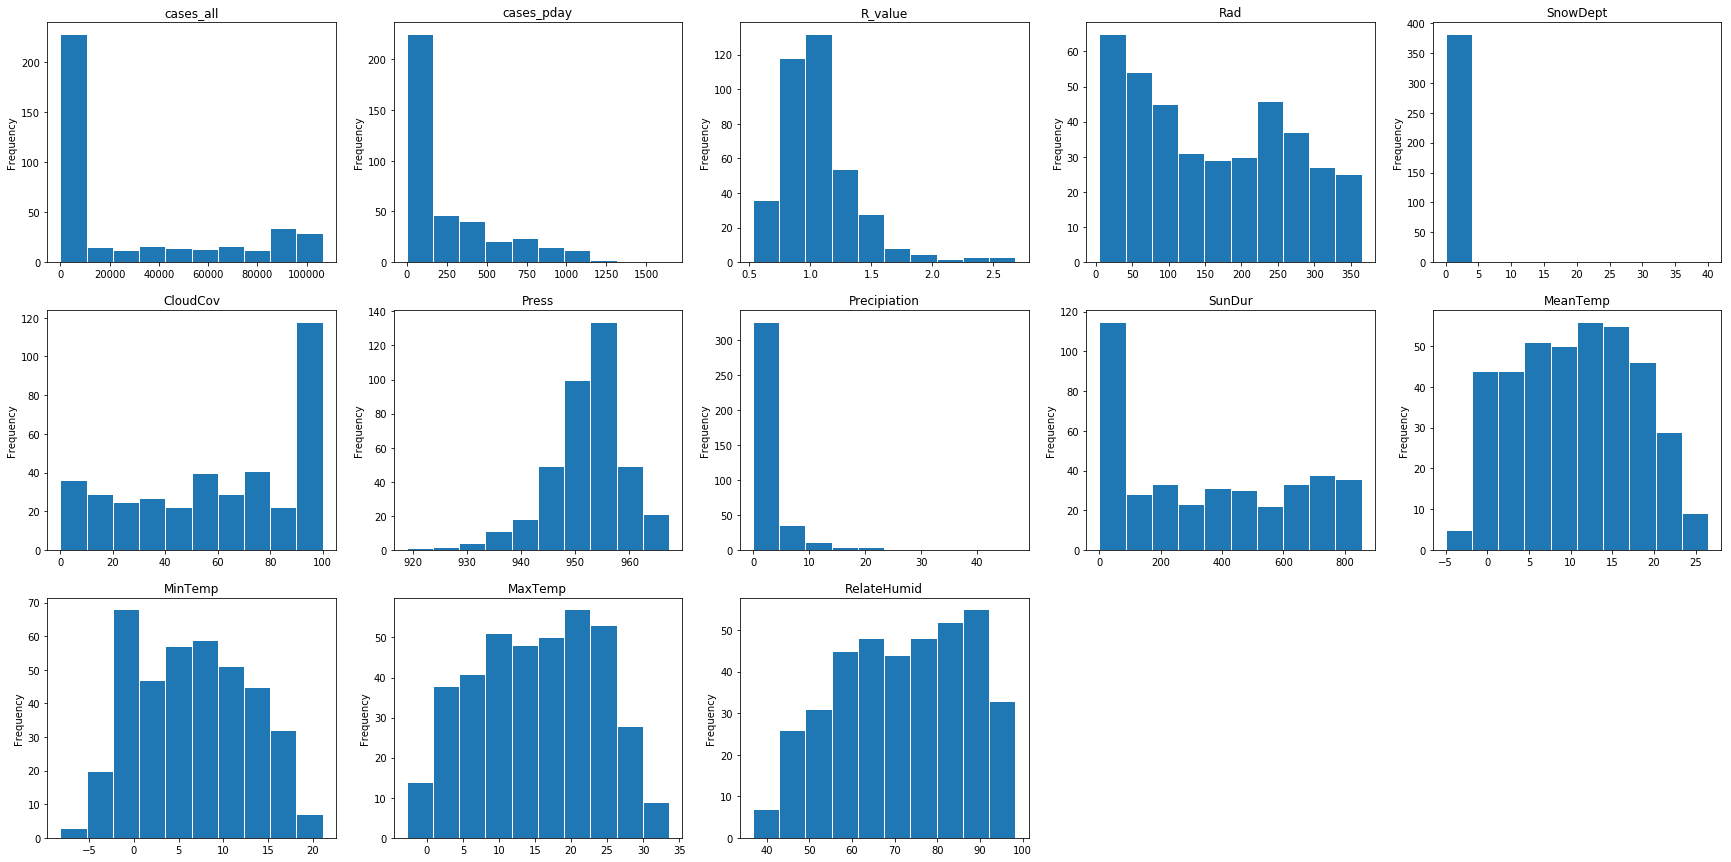

In [21]:
fig, axes = plt.subplots(3, 5, figsize=(30, 15))
for i, idx in enumerate(df.columns):
  df[idx].plot.hist(edgecolor='white', ax=axes.flat[i], title=idx)
fig.delaxes(axes[2,3])
fig.delaxes(axes[2,4])

### Summary Statistics
First, we compute the rolling 7-day average of the confirmed cases and visualize the results. The graphic shows the development of cases in the selected time frame.

In [22]:
avg7 = df.rolling(7, min_periods=1)['cases_pday'].mean()  

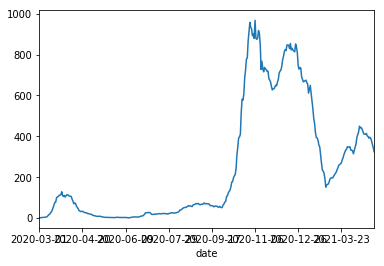

In [23]:
avg7.plot()



For the basic statistics of each column, we compute the quartile elements, median and the extreme values of each field.

In [24]:
# Compute quartile elements
df.quantile([0.25, 0.5, 0.75])

,cases_all,cases_pday,R_value,Rad,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
0.25,3618.0,20.0,0.90,64.0,33.0,948.6,0.0,40.0,4.7,1.0,8.6,59.5
0.50,6877.0,89.0,1.01,148.0,67.0,953.1,0.0,325.0,10.8,6.4,15.6,72.9
0.75,58902.0,408.0,1.19,246.0,92.0,956.3,1.5,628.0,16.3,11.4,22.4,84.8


In [25]:
# extreme values 
df.max()

cases_all       106565.00
cases_pday        1642.00
R_value              2.68
Rad                365.00
SnowDept            40.00
CloudCov           100.00
Press              967.30
Precipiation        46.80
SunDur             855.00
MeanTemp            26.50
MinTemp             21.10
MaxTemp             33.60
RelateHumid         98.30
dtype: float64

In [26]:
df.min()

cases_all         7.00
cases_pday        0.00
R_value           0.53
Rad               5.00
SnowDept          0.00
CloudCov          0.00
Press           918.90
Precipiation      0.00
SunDur            0.00
MeanTemp         -5.00
MinTemp          -8.20
MaxTemp          -2.80
RelateHumid      36.80
dtype: float64

In [27]:
# median
df.median()

cases_all       6877.00
cases_pday        89.00
R_value            1.01
Rad              148.00
SnowDept           0.00
CloudCov          67.00
Press            953.10
Precipiation       0.00
SunDur           325.00
MeanTemp          10.80
MinTemp            6.40
MaxTemp           15.60
RelateHumid       72.90
dtype: float64

###Pairwise Correlations
Compute the pairwise correlation of all columns.

In [28]:
# calculate the correlation matrix
corr = df0.corr()
corr

,cases_all,cases_pday,R_value,Rad,CloudCov,Press,Precipiation,SunDur,MeanTemp,MinTemp,MaxTemp,RelateHumid
cases_all,1.000000,0.479649,-0.215394,-0.285994,0.179718,0.051322,-0.046062,-0.208784,-0.574688,-0.594170,-0.535062,0.036521
cases_pday,0.479649,1.000000,-0.220178,-0.559062,0.309210,-0.001948,-0.036427,-0.399658,-0.546321,-0.480730,-0.573426,0.422268
R_value,-0.215394,-0.220178,1.000000,-0.109242,0.187696,-0.160049,0.051263,-0.157015,0.061690,0.129967,0.022792,0.175830
Rad,-0.285994,-0.559062,-0.109242,1.000000,-0.805510,0.245981,-0.279616,0.927068,0.674466,0.497609,0.764107,-0.806351
CloudCov,0.179718,0.309210,0.187696,-0.805510,1.000000,-0.368473,0.353364,-0.924304,-0.443439,-0.254038,-0.554415,0.739633
Press,0.051322,-0.001948,-0.160049,0.245981,-0.368473,1.000000,-0.266362,0.314598,0.095903,0.028708,0.142598,-0.212753
Precipiation,-0.046062,-0.036427,0.051263,-0.279616,0.353364,-0.266362,1.000000,-0.335258,-0.002290,0.061885,-0.048429,0.331859
SunDur,-0.208784,-0.399658,-0.157015,0.927068,-0.924304,0.314598,-0.335258,1.000000,0.550835,0.354120,0.659194,-0.794980
MeanTemp,-0.574688,-0.546321,0.061690,0.674466,-0.443439,0.095903,-0.002290,0.550835,1.000000,0.961547,0.981197,-0.408393
MinTemp,-0.594170,-0.480730,0.129967,0.497609,-0.254038,0.028708,0.061885,0.354120,0.961547,1.000000,0.900624,-0.209737


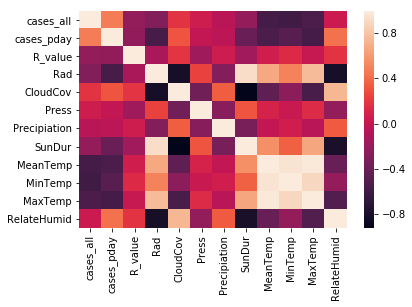

In [29]:
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

## 3. Linear Regression

ValueError: color kwarg must have one color per data set. 389 data sets and 1 colors were provided

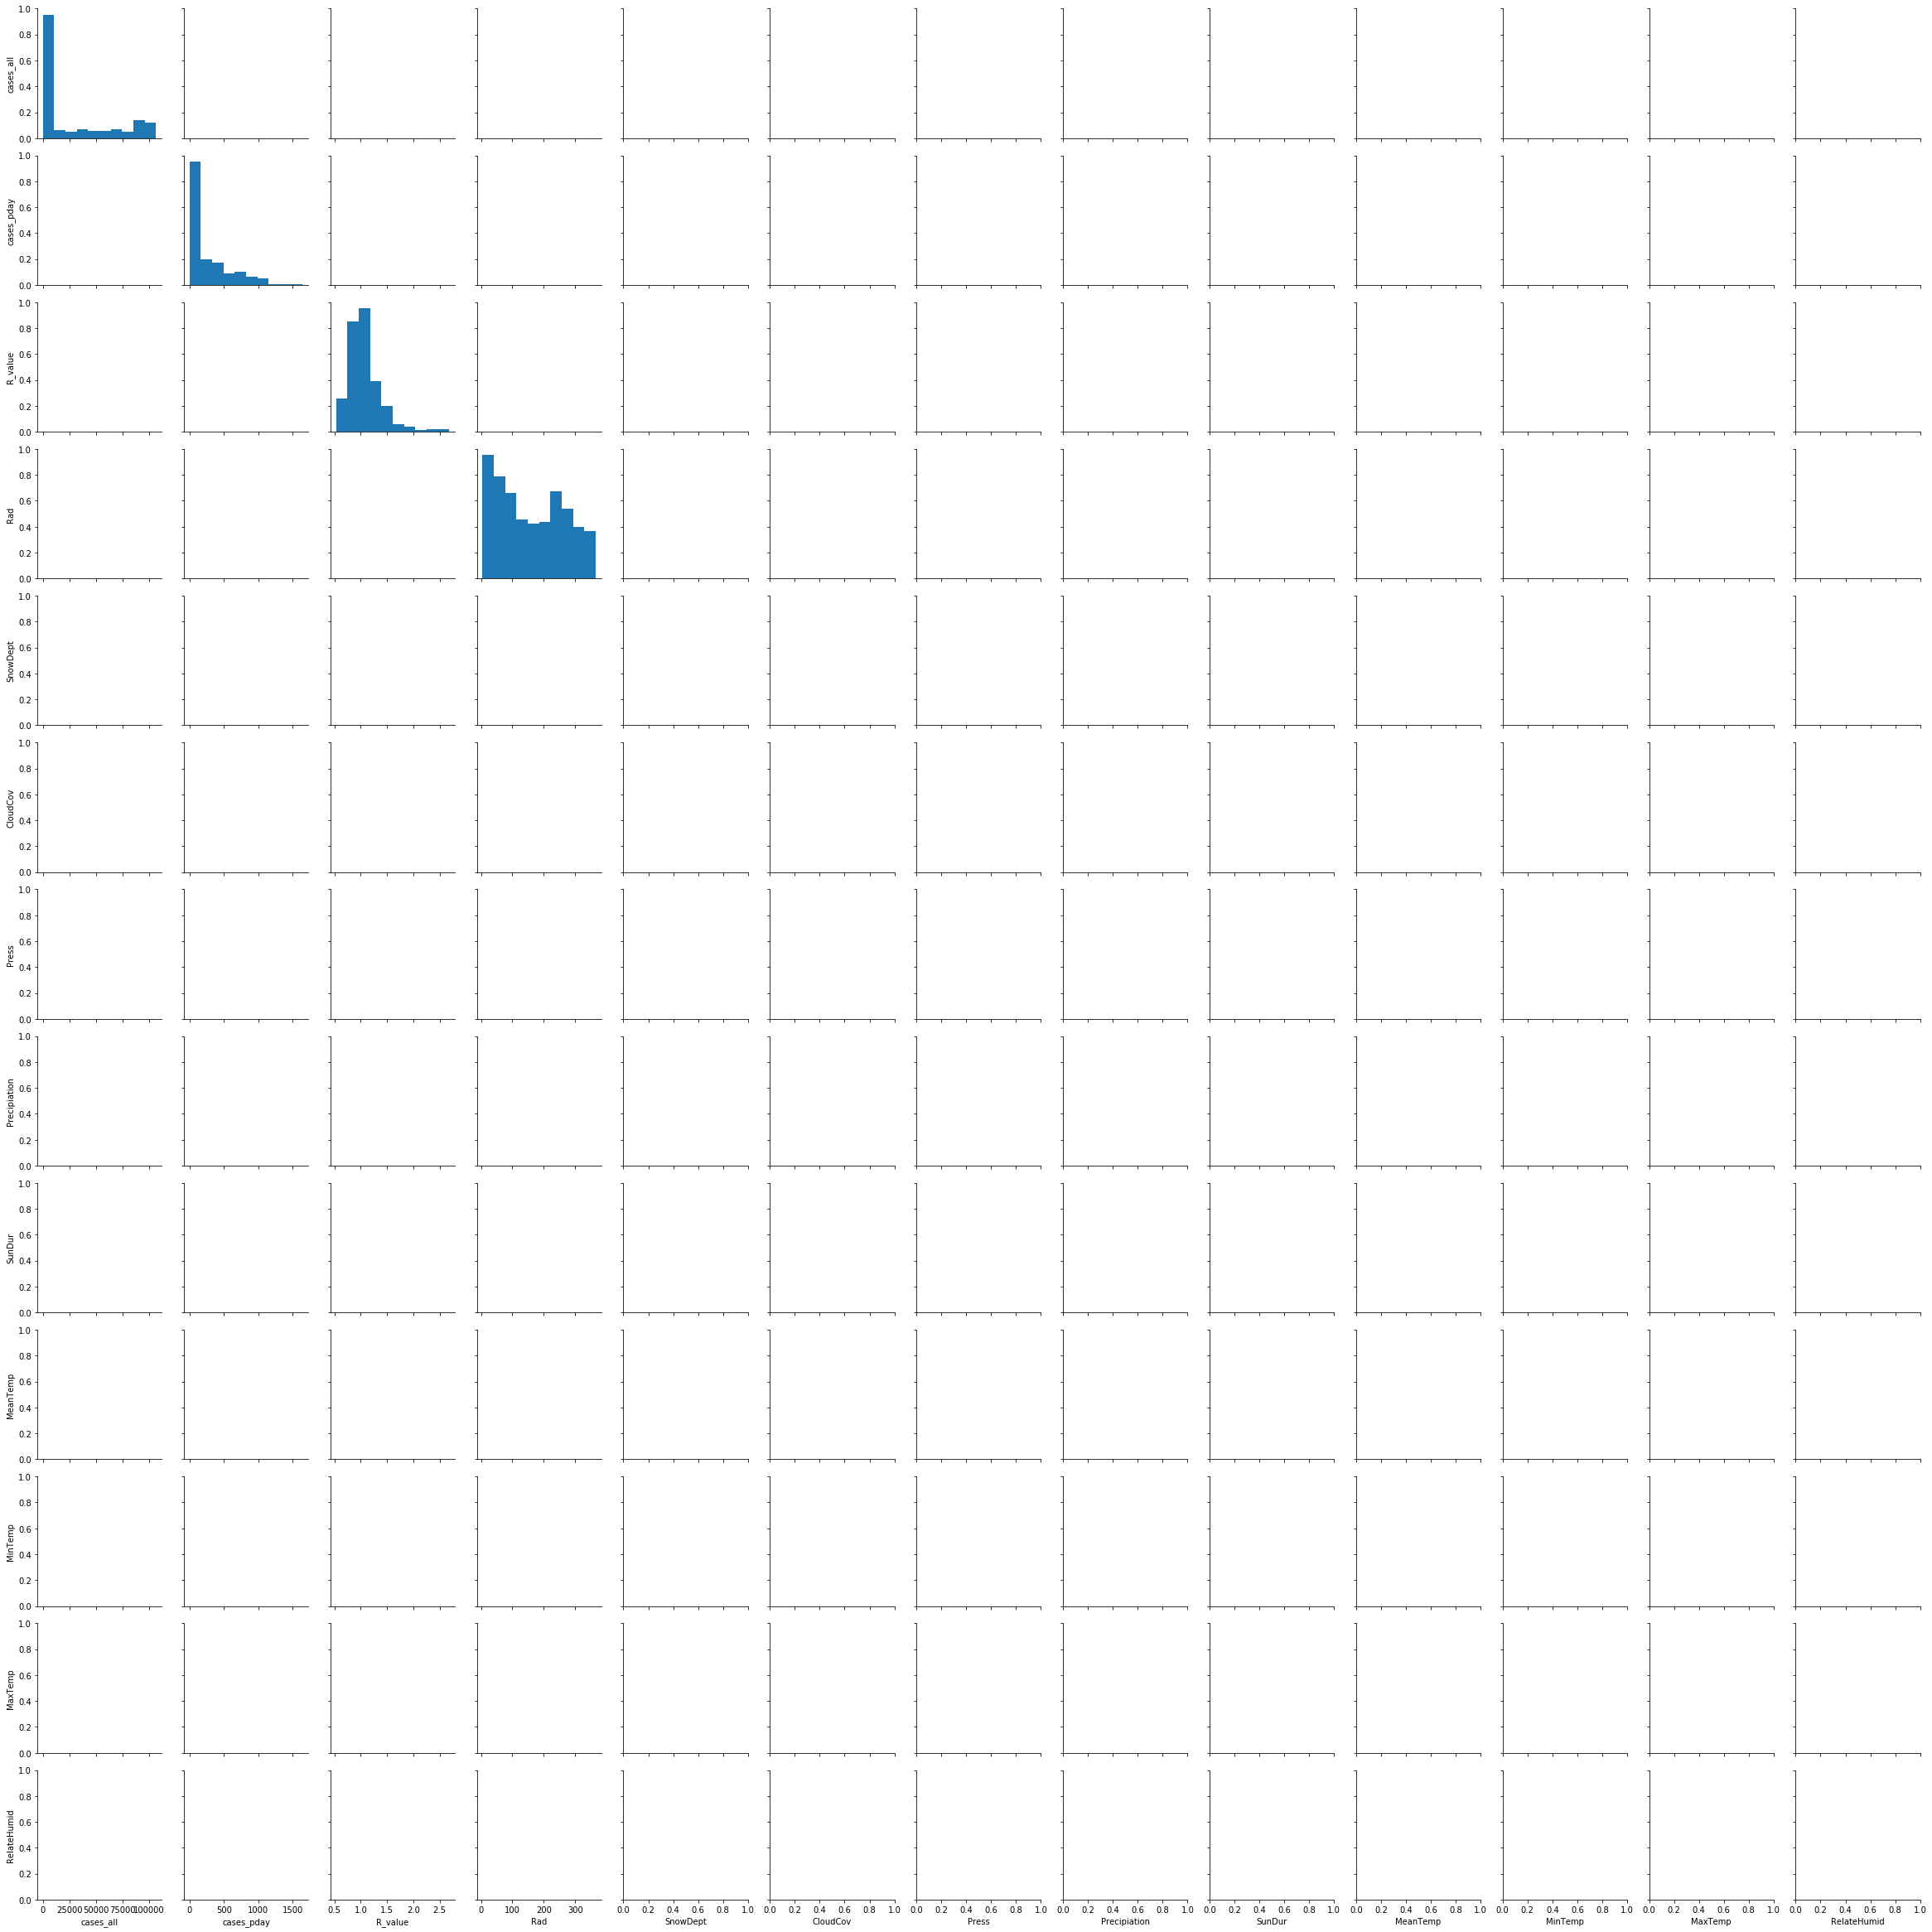

In [33]:
#df0= df.reset_index()

sns.pairplot(df0)
plt.show()

Check the correlation 

In [34]:
df0.corrwith(df0.cases_pday)

cases_all       0.479649
cases_pday      1.000000
R_value        -0.220178
Rad            -0.559062
CloudCov        0.309210
Press          -0.001948
Precipiation   -0.036427
SunDur         -0.399658
MeanTemp       -0.546321
MinTemp        -0.480730
MaxTemp        -0.573426
RelateHumid     0.422268
dtype: float64

Detecting multi-linearity

In [35]:
y, X = dmatrices('cases_pday~Rad+CloudCov+Press+Precipiation+SunDur+MeanTemp+MinTemp+MaxTemp+RelateHumid', data = df0, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif


,VIF Factor,features
0,22068.508289,Intercept
1,13.280679,Rad
2,8.475899,CloudCov
3,1.208732,Press
4,1.289689,Precipiation
5,20.796282,SunDur
6,200.088181,MeanTemp
7,51.830874,MinTemp
8,87.890689,MaxTemp
9,3.766298,RelateHumid


We use Ridge regression to reduce multi-linearity.

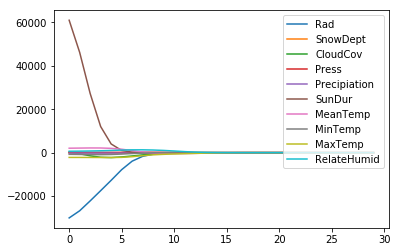

In [36]:
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T*xMat
    denom = xTx + np.eye(np.shape(xMat)[1])*lam
    if np.linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T*yMat)
    return ws
 
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr); yMat=np.mat(yArr).T
    yMean = np.mean(yMat) 
    # print(yMean)
    yMat = yMat - yMean
    # print(xMat)
    #regularize X's
    xMeans = np.mean(xMat,0)
    xVar = np.var(xMat,0)
    xMat = (xMat - xMeans) / xVar 
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    for i in range(numTestPts): 
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))
        wMat[i,:]=ws.T
    return wMat
 
# import data
xArr =df0.iloc[:,4:].astype(float)
yArr = df0.iloc[:,2].astype(float)
 
# print(xArr,yArr)
ridgeWeights = ridgeTest(xArr,yArr)
# print(ridgeWeights)
plt.plot(ridgeWeights)
plt.legend(xArr.columns,loc='upper right')
plt.show()

Delete variables which have significant multi-linearity

In [37]:
y, X = dmatrices('cases_pday~Rad+CloudCov+Press+Precipiation+MeanTemp+RelateHumid', data = df0, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,21999.094955,Intercept
1,6.519589,Rad
2,3.457994,CloudCov
3,1.204096,Press
4,1.242455,Precipiation
5,2.167374,MeanTemp
6,3.341231,RelateHumid


Now we fit the model

In [38]:
random.seed(10)
fit = sm.formula.ols('cases_pday~Rad+CloudCov+Press+Precipiation+MeanTemp+RelateHumid', data = df0).fit()
fit.summary()
fit_new = sm.formula.ols('cases_pday~Rad+CloudCov+Precipiation+MeanTemp+RelateHumid', data = df0).fit()
fit_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cases_pday   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     55.44
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           2.86e-43
Time:                        17:30:01   Log-Likelihood:                -2684.0
No. Observations:                 389   AIC:                             5380.
Df Residuals:                     383   BIC:                             5404.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      652.3449    136.001      4.797      0.000     384.943     919.747
Rad             -1.7580      0.299     -5.874      0.000      -2.346      -1.170
CloudCov        -3.0874      0.673     -4.588      0.000      -4.410      -1.764
Precipiation    -7.6750      2.499     -3.071      0.002     -12.588      -2.762
MeanTemp       -10.7132      2.555     -4.193      0.000     -15.737      -5.690
RelateHumid      2.7880      1.477      1.888      0.060      -0.115       5.691
==============================================================================
Omnibus:                       70.105   Durbin-Watson:                   0.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.157
Skew:                           1.031   Prob(JB):                     1.81e-27
Kurtosis:                       4.830   Cond. No.                     2.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
pred = fit_new.predict()
np.sqrt(mean_squared_error(df0.cases_pday, pred))

240.01506523858743

See if there are outliers.

In [40]:
#student residuals
outliers = fit_new.get_influence()
resid_stu = outliers.resid_studentized_external
leverage = outliers.hat_matrix_diag
# dffits
dffits = outliers.dffits[0]

contat1 = pd.concat([pd.Series(leverage, name = 'leverage'),pd.Series(dffits, name = 'dffits'),
                     pd.Series(resid_stu,name = 'resid_stu'),],axis = 1)

contat1.head()


,leverage,dffits,resid_stu
0,0.005557,-0.105367,-1.409483
1,0.008346,-0.157856,-1.720675
2,0.014550,-0.133465,-1.098364
3,0.009275,-0.116289,-1.201850
4,0.016453,-0.207482,-1.604186


In [41]:
outliers_ratio = sum(np.where((np.abs(contat1.resid_stu)>2),1,0))/contat1.shape[0]
outliers_ratio


0.04627249357326478

The outliers ratio is less than 5%, so we can directly delete those outliers.


In [42]:
df_outliers_comb = pd.concat([df0,contat1], axis = 1)
df0_outliers_del = df_outliers_comb.loc[np.abs(df_outliers_comb.resid_stu)<=2,]

Now we use the new data to build the model.

$$cases\_pday =  \beta_0 + \beta_1 \times Rad +\beta_2 \times CloudCov  +\beta_3 \times Precipiation  +\beta_4 \times MeanTemp +\beta_5 \times RelateHumid + \epsilon$$

In [43]:
fit2 = sm.formula.ols('cases_pday~Rad+CloudCov+Precipiation+MeanTemp+RelateHumid',data = df0_outliers_del).fit()
fit2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cases_pday   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     63.99
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           7.77e-48
Time:                        17:30:04   Log-Likelihood:                -2476.9
No. Observations:                 371   AIC:                             4966.
Df Residuals:                     365   BIC:                             4989.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      533.6786    111.075      4.805      0.000     315.252     752.106
Rad             -1.0922      0.248     -4.409      0.000      -1.579      -0.605
CloudCov        -2.3150      0.549     -4.220      0.000      -3.394      -1.236
Precipiation    -6.4964      2.038     -3.188      0.002     -10.504      -2.489
MeanTemp       -14.7896      2.082     -7.105      0.000     -18.883     -10.696
RelateHumid      2.4483      1.203      2.034      0.043       0.082       4.815
==============================================================================
Omnibus:                       22.650   Durbin-Watson:                   0.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.376
Skew:                           0.638   Prob(JB):                     3.09e-06
Kurtosis:                       3.111   Cond. No.                     2.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The result is significant, each varible is significant as well(p_value<0.05).

In [44]:
# RMSE value
pred2 = fit2.predict()
np.sqrt(mean_squared_error(df0_outliers_del.cases_pday, pred2))

191.98491435385782

Finally we test the residual normality.

In [45]:
#shapiro test
resid = fit2.resid

stats.shapiro(resid)

(0.9633582234382629, 5.166603500583733e-08)

## 4. Result & Conclusion

As the model results show, all parameters are statistically significant (p-value < 0.05). The model:
                                              
$$cases\_pday = -1.0992 \times Rad -2.3150 \times CloudCov -6.4964 \times Precipiation -14.7896 \times MeanTemp + 2.4483 \times RelateHumid + 533.6786$$

According to WHO ("Coronavirus disease (COVID-19): How is it transmitted?", 2021), the coronavirus mainly transmitted among people in two ways. One is close contact, which means people are within 1 meter distance. The other one is people are in "poorly ventilated and/or crowded indoor settings", where they tend to spend quite long time. These two senarios usually happened when there are family gatherings, sport events, large conferences, parties and so on.

Our intention is to see how weather factors affect corona cases per day in Zurich kanton. However, wheather factors cannot influence it directly, these factors somehow have an impact by having some effects on people's behavior.

This model turns out precipitation (the statistics show the amount of rain or snow) has a negative correlation with coronavirus cases per day. With a 1 mm raises in precipitation, the number of coronavirus cases per day will decrease by 6.4964 cases. The model also shows when there is 1 degree rise in temperature, the number of coronavirus cases per day will decrease by 14.7896 per day. The model result shows that when the humidity rises by 1 percent, the daily coronavirus cases will also rise by 2.4483 cases. 

At very beginning of this analysis, we suppose that people's behaviors have certain connections with weather conditions, then they have some impacts on the spread of coronavirus.

People tend to have more contacts during family events, sport events or other social events. By observing our model results, we could see a tendency that people have more above mentioned events in certain weather secenarios than other weather conditions.

However, we cannot simply conclude that "sunny", "cloudy" or "rainy" days has correlation with daily coronavirus cases. It is more reasonable to conclude that a balanced combination with these factors (global radiation, cloud cover, precipiation, daily mean air temeprature and relative air humidity) relates to more coronavirus cases.

## 5. References

Coronavirus disease (COVID-19): How is it transmitted?. (2021). Retrieved 11 June 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019/question-and-answers-hub/q-a-detail/coronavirus-disease-covid-19-how-is-it-transmitted